In [1]:
### Data Analisy Libraries ###
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
from datetime import datetime, time, date as dt


from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, KFold, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel, VarianceThreshold, SelectPercentile
from sklearn import set_config


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from math import sqrt




#pd.options.display.float_format = '{:.2f}'.format
pd.set_option("display.max_columns", 35)


data_raw =  pd.read_csv('../dataset/kc_house_data.csv', low_memory=False)

* <b>Machine Learning Model</b><br>
    * Preprocessing
        - Encoding
        - Dimnensionality Reduction
        - Standardization
    * Pipelines
        - Linear Regression
        - Random Forest
        - XGBosst       
    * Holdout Validation(Split Test-Train)
    * Cross Validation k-Fold           
    * Hyperparamters Tunning<br> <br>      


In [831]:
data = data_raw.copy()

In [832]:
data.drop_duplicates(subset=['id'], inplace=True, keep='last')
data['date'] = pd.to_datetime(data['date'])
data['week_of_year'] = data['date'].dt.isocalendar().week
data = data.astype({"week_of_year": int})
bad_values = ((data['bedrooms'] > 10))
data = data[~bad_values]

In [833]:
data["house_age"] = data["date"].dt.year - data['yr_built']
data['renovated'] = data['yr_renovated'].apply(lambda yr: 0 if yr == 0 else 1)

In [834]:
modify_data = data.copy()

In [835]:
#num_attributes.hist(figsize=(18,15), bins='auto');

In [836]:
zipsorted = pd.DataFrame(data.groupby('zipcode')['price'].median().sort_values(ascending=True))
zipsorted['rank'] = np.divmod(np.arange(len(zipsorted)), 1)[0]+1
zipsorted

,price,rank
zipcode,,
98002,235000.0,1
98168,237000.0,2
98032,250000.0,3
98001,260000.0,4
98188,265000.0,5
...,...,...
98005,765475.0,66
98112,917500.0,67
98040,993750.0,68


<AxesSubplot:xlabel='rank', ylabel='price'>

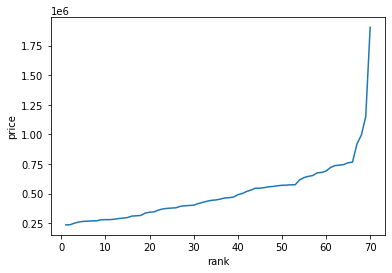

In [837]:
sns.lineplot(data=zipsorted, x="rank", y="price")

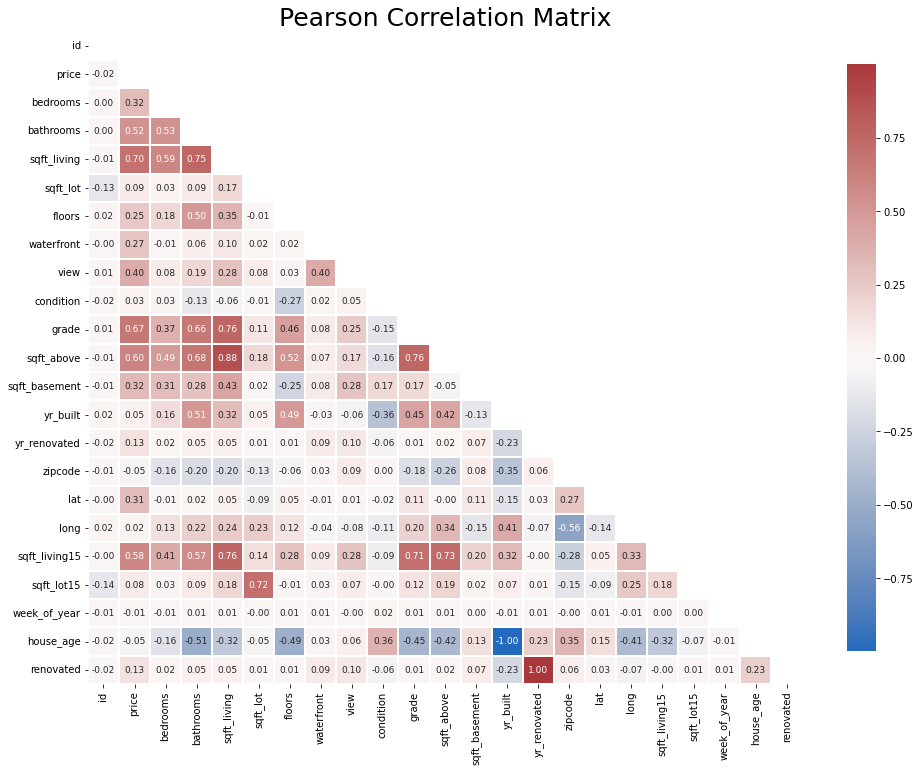

In [838]:
mask = np.zeros_like(data[modify_data.columns].corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(data[modify_data.columns].corr(),linewidths=0.25,fmt=".2f", cmap="vlag", linecolor='w',annot=True,annot_kws={"size":9},mask=mask,cbar_kws={"shrink": .9});

In [839]:
num_features.corr()['price'].abs().sort_values(ascending = False)

price            1.000000
sqft_living      0.701425
grade            0.666326
sqft_above       0.604650
sqft_living15    0.583955
bathrooms        0.524454
view             0.396607
sqft_basement    0.323970
bedrooms         0.316401
lat              0.306749
waterfront       0.266968
floors           0.254981
yr_renovated     0.126720
renovated        0.126385
sqft_lot         0.088575
sqft_lot15       0.081649
yr_built         0.051082
house_age        0.051057
zipcode          0.050973
condition        0.034506
long             0.019423
id               0.018429
Name: price, dtype: float64

In [840]:
numerical_features = modify_data.select_dtypes( include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
drop_features = ['id','date','yr_built','yr_renovated']

In [841]:
modify_data = modify_data.drop(drop_features, axis=1)

In [842]:
modify_data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,week_of_year,house_age,renovated
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,98178,47.5112,-122.257,1340,5650,42,59,0
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,98125,47.7210,-122.319,1690,7639,50,63,1
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,98028,47.7379,-122.233,2720,8062,9,82,0
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,98136,47.5208,-122.393,1360,5000,50,49,0
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,98074,47.6168,-122.045,1800,7503,8,28,0


# Resccaling

In [843]:
y = modify_data["price"]
X = modify_data.drop(["price"], axis=1)

In [844]:
sc= StandardScaler()
rs = RobustScaler()
mms = MinMaxScaler()

In [845]:
X[['sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15','sqft_lot15']] = mms.fit_transform(X[['sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15','sqft_lot15']].values)

In [846]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=True)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((15003, 19), (15003,), (6431, 19), (6431,))

In [ ]:
X_train.head()

In [ ]:
lr.fit(X_train,y_train)

In [857]:
y_pred=rf.predict(X_test)

In [858]:
print(f'Coeficient: {lr.coef_}')
print(f'\n Intercept: {lr.intercept_}')


Coeficient: [-4.32662667e+04  4.40463089e+04  9.11553068e+05  3.29703348e+05
  6.04764807e+03  5.99085947e+05  4.92689845e+04  2.52306436e+04
  9.28408484e+04  1.09032769e+06  4.42798683e+05 -6.00688753e+02
  6.04026727e+05 -2.17811704e+05  1.11069670e+05 -3.67995847e+05
 -5.44738913e+02  2.65417223e+03  4.05040142e+04]

 Intercept: 2878432.9340506373


In [859]:
print('Mean squared error (MSE): %.2f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination (R^2): %.4f' %  r2_score(y_test, y_pred))

Mean squared error (MSE): 19450685681.60
Coefficient of determination (R^2): 0.8601


# crossval

In [860]:
seed = 7
number_folds = 4
Kfold = KFold(n_splits=number_folds, shuffle=True, random_state=seed)

In [861]:
lr = LinearRegression()
rf = RandomForestRegressor()
dt = DecisionTreeRegressor()
gb = GradientBoostingRegressor()

In [862]:
models = [lr,rf,dt,gbr]
model_dict = {0:'Linear Regression', 1:'Random Forest Regressor', 2:'Decision Tree Regressor', 3:'Gradient Boost Regressor'}

*****************************************************
Machine Learning algorithm: LinearRegression()
*****************************************************
R²: 0.6977 +/- 0.0037
RMSE: 40253249856 +/- 55513
MAE: 125340 +/- 1521
MAPE: 0.2546 +/- 0.0020


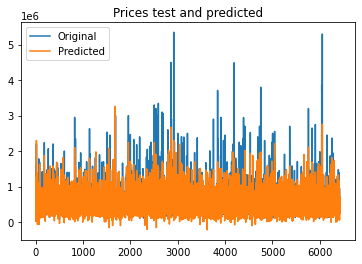

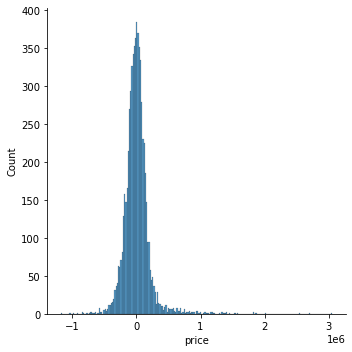

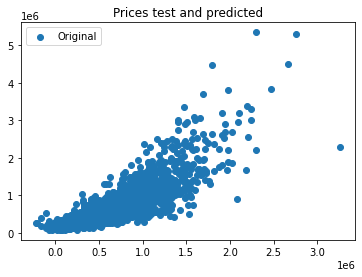

*****************************************************
Machine Learning algorithm: RandomForestRegressor()
*****************************************************
R²: 0.8729 +/- 0.0023
RMSE: 16911231183 +/- 32424
MAE: 70636 +/- 1181
MAPE: 0.1318 +/- 0.0014


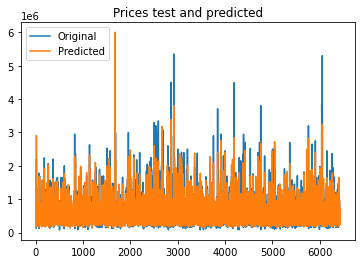

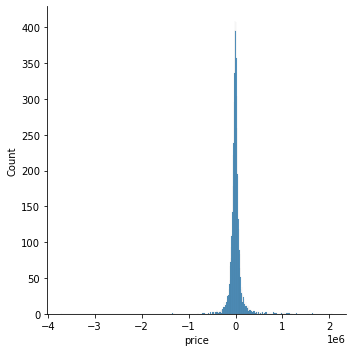

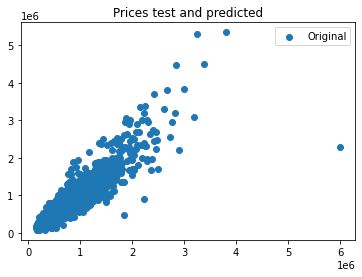

*****************************************************
Machine Learning algorithm: DecisionTreeRegressor()
*****************************************************
R²: 0.7478 +/- 0.0054
RMSE: 33590791540 +/- 51538
MAE: 102994 +/- 2121
MAPE: 0.1896 +/- 0.0016


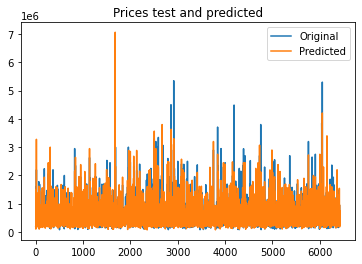

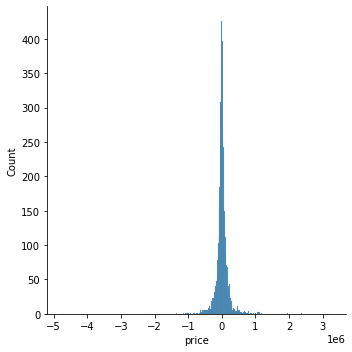

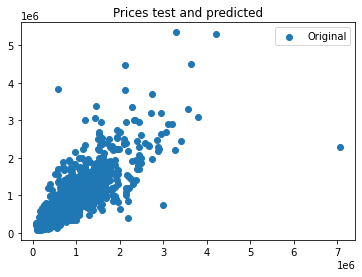

*****************************************************
Machine Learning algorithm: GradientBoostingRegressor()
*****************************************************
R²: 0.8709 +/- 0.0040
RMSE: 17150099671 +/- 25045
MAE: 77057 +/- 1149
MAPE: 0.1467 +/- 0.0019


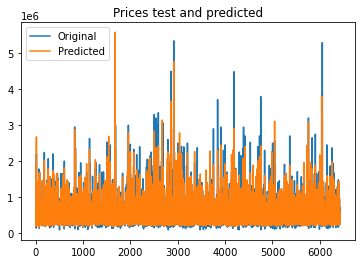

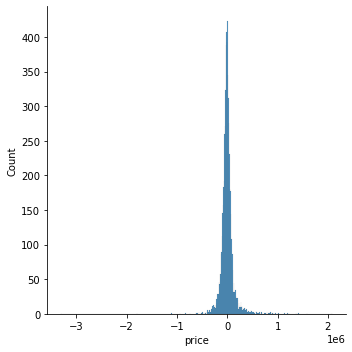

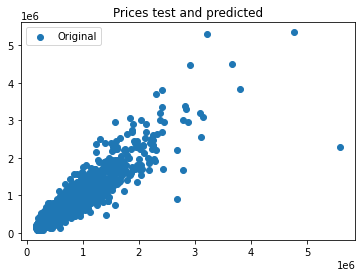

Wall time: 36.7 s


In [863]:
%%time
np.random.seed(7)

score_metrics_cv = pd.DataFrame(columns=['Method','R²','RMSE','MAE','MAPE'])

results_r2 = []
results_rmse =[]
results_mae =[]
results_mape =[]
names = []
predictions =[]
results=[]

for i,model in enumerate(models): 
    print('*' * 53) 
    print(f"Machine Learning algorithm: {models[i]}") 
    print('*' * 53)     
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    
    scores = cross_validate(model, X_train, y_train, cv = 3, scoring=("r2","neg_mean_squared_error", "neg_mean_absolute_error","neg_mean_absolute_percentage_error"))
    print(f"R²: {scores['test_r2'].mean():.4f} +/- {scores['test_r2'].std():.4f}")
    print(f"RMSE: {scores['test_neg_mean_squared_error'].mean()*-1**0.5:.0f} +/- {scores['test_neg_mean_squared_error'].std()**0.5:.0f}")   
    print(f"MAE: {scores['test_neg_mean_absolute_error'].mean()*-1:.0f} +/- {scores['test_neg_mean_absolute_error'].std():.0f}") 
    print(f"MAPE: {scores['test_neg_mean_absolute_percentage_error'].mean()*-1:.4f} +/- {scores['test_neg_mean_absolute_percentage_error'].std():.4f}")
    
    fig1(y_test,y_pred)
    fig2(y_test,y_pred)
    fig3(y_test,y_pred)
    
    score_metrics_cv.loc[i] = (model_dict[i], scores['test_r2'].mean(), 
                               scores['test_neg_mean_squared_error'].mean()*-1**0.5,
                               scores['test_neg_mean_absolute_error'].mean()*-1, 
                               scores['test_neg_mean_absolute_percentage_error'].mean()*-1) 

    results_r2.append(scores['test_r2'])
    results_rmse.append(scores['test_neg_mean_squared_error'])
    results_mae.append(scores['test_neg_mean_absolute_error'])
    results_mape.append(scores['test_neg_mean_absolute_percentage_error'])    

    results.append(scores['test_neg_mean_squared_error']*-1**0.5)
    predictions.append(y_pred)
    names.append(model_dict[i])


In [864]:
def fig1(y_teste,y_pred,*):
    #x_ax = range(len(y_test))
    plt.plot(range(len(y_test)), y_test,  label="Original")
    plt.plot(range(len(y_test)), y_pred, label="Predicted")
    plt.title("Prices test and predicted")
    plt.legend()
    plt.show()

SyntaxError: named arguments must follow bare * (Temp/ipykernel_19920/597625571.py, line 1)

In [ ]:
def fig2(y_test,y_pred):
    residuals=y_test-y_pred
    sns.displot(residuals,kde=False)
    plt.show()

In [ ]:
def fig3(y_test,y_pred):
    plt.scatter(y_pred, y_test, label="Original")
    plt.title("Prices test and predicted")
    plt.legend()
    plt.show()

In [ ]:
fig1(y_test,y_pred)

In [ ]:
score_metrics_cv

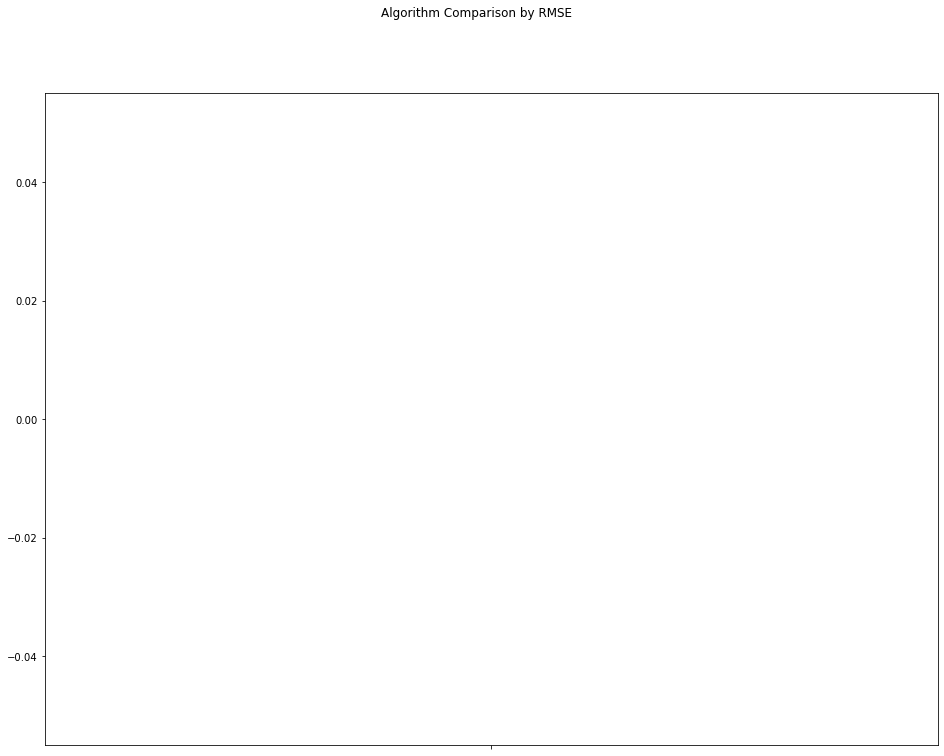

In [827]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison by RMSE')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
categorical_features = ['pclass', 'sex', 'embarked']
categorical_transformer = Pipeline(
    [
        ('imputer_cat', SimpleImputer(strategy = 'constant', fill_value = 'missing')),
        ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
    ]
)

numeric_features = ['age', 'sibsp', 'parch', 'fare']
numeric_transformer = Pipeline(
    [
        ('imputer_num', SimpleImputer(strategy = 'median')),
        ('scaler', StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    [
        ('categoricals', categorical_transformer, categorical_features),
        ('numericals', numeric_transformer, numeric_features)
    ],
    remainder = 'drop'
)

pipeline = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('clf', LogisticRegression())
    ]
)

params = {
    'clf__solver': ['liblinear'],
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__random_state': [42]
}

In [696]:
'''
seed = 7



preprocessor = ColumnTransformer(transformers=
    [
        ('std', MinMaxScaler(), numerical_features)        
    ]
)

'''
pipeline_lr = Pipeline(steps=[('std', MinMaxScaler()),
              ('classifier', lr)
])


pipeline_rf = Pipeline(steps=[('std', MinMaxScaler()),
              ('classifier', rf)
])


pipeline_lr

Pipeline(steps=[('std', MinMaxScaler()), ('classifier', LinearRegression())])

In [699]:
%%time
### Tunning parameters: Logistic Regression ###

np.random.seed(7)

params1 = { 
        'std':[StandardScaler(), MinMaxScaler(), RobustScaler()],
        #'classifier__C' : [0.1,1,10], 
        #'classifier__C': [0.1,1,10], 
        # 'classifier__solver': ['lbfgs','saga'] 
        #'classifier__penalty': ['l1','l2']

}


params1['classifier'] = [lr] 


gs = GridSearchCV(pipeline_lr, params1, cv=Kfold, scoring='precision',verbose=True, n_jobs =-1, return_train_score=False)
gs.fit(X_train,y_train)

lr_tuning_score = gs.best_score_

print(f"\nPrecision Best Score:{gs.best_score_}") 
print(f"\nBest Paramters:\n{gs.best_params_}") 
print(f"\nBest Estimator:\n{gs.best_estimator_}") 

Fitting 4 folds for each of 3 candidates, totalling 12 fits


C:\Users\Alysson\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(



Precision Best Score:nan

Best Paramters:
{'classifier': LinearRegression(), 'std': StandardScaler()}

Best Estimator:
Pipeline(steps=[('std', StandardScaler()), ('classifier', LinearRegression())])
Wall time: 13.4 s


In [698]:
%%time
### Tunning parameters: Random Forest

np.random.seed(7)

params2 = { 
        'std' : [MinMaxScaler(), StandardScaler()],
        'classifier': [RandomForestRegressor()],
        'classifier__criterion' : ['gini', 'entropy'],
        #'classifier__max_depth': [1, 5]
        # 'classifier__n_estimators' : [200,400]
        # 'classifier__min_samples_leaf' : [1, 3, 5]
       
}

#params2['classifier'] = [rf]

gs = GridSearchCV(estimator=pipeline_rf, param_grid=params2, cv=Kfold, scoring="r2", verbose=True)
gs.fit(X_train,y_train)

rt_tuning_score = gs.best_score_

print(f"\nPrecision Best Score:{gs.best_score_}") 
print(f"\nBest Paramters:\n{gs.best_params_}") 
print(f"\nBest Estimator:\n{gs.best_estimator_}") 

Fitting 4 folds for each of 4 candidates, totalling 16 fits


ValueError: 
All the 16 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Alysson\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Alysson\anaconda3\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Alysson\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "C:\Users\Alysson\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Alysson\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Alysson\anaconda3\lib\site-packages\joblib\parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Alysson\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "C:\Users\Alysson\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "C:\Users\Alysson\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "C:\Users\Alysson\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "C:\Users\Alysson\anaconda3\lib\site-packages\sklearn\utils\fixes.py", line 117, in __call__
    return self.function(*args, **kwargs)
  File "C:\Users\Alysson\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 189, in _parallel_build_trees
    tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
  File "C:\Users\Alysson\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1342, in fit
    super().fit(
  File "C:\Users\Alysson\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 394, in fit
    criterion = CRITERIA_REG[self.criterion](self.n_outputs_, n_samples)
KeyError: 'gini'

--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Alysson\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Alysson\anaconda3\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Alysson\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "C:\Users\Alysson\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Alysson\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Alysson\anaconda3\lib\site-packages\joblib\parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Alysson\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "C:\Users\Alysson\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "C:\Users\Alysson\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "C:\Users\Alysson\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "C:\Users\Alysson\anaconda3\lib\site-packages\sklearn\utils\fixes.py", line 117, in __call__
    return self.function(*args, **kwargs)
  File "C:\Users\Alysson\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 189, in _parallel_build_trees
    tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
  File "C:\Users\Alysson\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1342, in fit
    super().fit(
  File "C:\Users\Alysson\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 394, in fit
    criterion = CRITERIA_REG[self.criterion](self.n_outputs_, n_samples)
KeyError: 'entropy'
